# 01- Usage of the ARCH package

_This setup code is required to run in an IPython notebook_

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")
plt.rc("figure", figsize=(16, 6))
plt.rc("savefig", dpi=90)
plt.rc("font", family="sans-serif")
plt.rc("font", size=14)

## Data
These examples make use of S&P 500 data from Yahoo! that is available from `arch.data.sp500`.

In [3]:
import datetime as dt
import sys

import arch.data.sp500
import numpy as np
import pandas as pd
from arch import arch_model

data = arch.data.sp500.load()
market = data["Adj Close"]
returns = 100 * market.pct_change().dropna()

In [4]:
returns

Date
1999-01-05    1.358200
1999-01-06    2.214041
1999-01-07   -0.205133
1999-01-08    0.422136
1999-01-11   -0.879151
                ...   
2018-12-24   -2.711225
2018-12-26    4.959374
2018-12-27    0.856268
2018-12-28   -0.124158
2018-12-31    0.849248
Name: Adj Close, Length: 5030, dtype: float64

<Axes: xlabel='Date'>

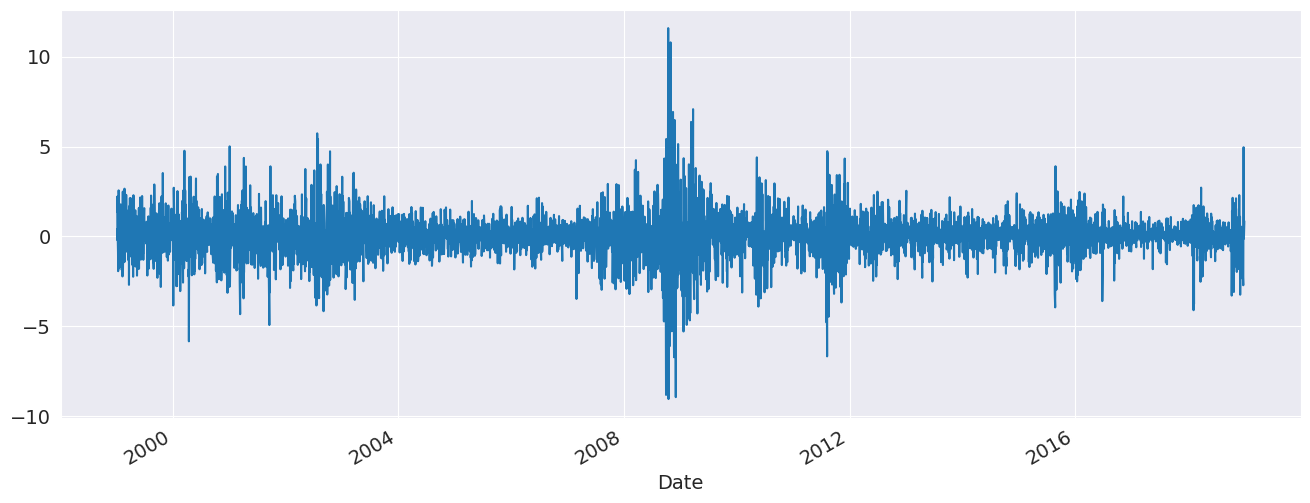

In [5]:
returns.plot()

In [6]:
arch_model?

Signature:
arch_model(
    y: 'ArrayLike | None',
    x: 'ArrayLike2D | None' = None,
    mean: "Literal['Constant', 'Zero', 'LS', 'AR', 'ARX', 'HAR', 'HARX', 'constant', 'zero']" = 'Constant',
    lags: 'None | int | list[int] | Int32Array | Int64Array' = 0,
    vol: "Literal['GARCH', 'ARCH', 'EGARCH', 'FIGARCH', 'APARCH', 'HARCH', 'FIGARCH']" = 'GARCH',
    p: 'int | list[int]' = 1,
    o: 'int' = 0,
    q: 'int' = 1,
    power: 'float' = 2.0,
    dist: "Literal['normal', 'gaussian', 't', 'studentst', 'skewstudent', 'skewt', 'ged', 'generalized error']" = 'normal',
    hold_back: 'int | None' = None,
    rescale: 'bool | None' = None,
) -> 'HARX'
Docstring:
Initialization of common ARCH model specifications

Parameters
----------
y : {ndarray, Series, None}
    The dependent variable
x : {np.array, DataFrame}, optional
    Exogenous regressors.  Ignored if model does not permit exogenous
    regressors.
mean : str, optional
    Name of the mean model.  Currently supported options are

## Does anything beat GARCH(1,1)

In [29]:
am = arch_model(returns, vol="Garch", p=1, o=0, q=1, dist="Normal")
res = am.fit(update_freq=5)

Iteration:      5,   Func. Count:     35,   Neg. LLF: 6970.277818445006
Iteration:     10,   Func. Count:     63,   Neg. LLF: 6936.718477482898
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6936.718476989025
            Iterations: 11
            Function evaluations: 68
            Gradient evaluations: 11


In [30]:
print(res.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -6936.72
Distribution:                  Normal   AIC:                           13881.4
Method:            Maximum Likelihood   BIC:                           13907.5
                                        No. Observations:                 5030
Date:                Tue, Apr 18 2023   Df Residuals:                     5029
Time:                        14:30:29   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0564  1.149e-02      4.906  9.302e-07 [3.

In [31]:
type(res)

arch.univariate.base.ARCHModelResult

In [32]:
am.fit?

Signature:
am.fit(
    update_freq: 'int' = 1,
    disp: "bool | Literal['off', 'final']" = 'final',
    starting_values: 'ArrayLike1D | None' = None,
    cov_type: "Literal['robust', 'classic']" = 'robust',
    first_obs: 'int | DateLike | None' = None,
    last_obs: 'int | DateLike | None' = None,
    tol: 'float | None' = None,
    options: 'dict[str, Any] | None' = None,
    backcast: 'None | float | Float64Array' = None,
) -> 'ARCHModelResult'
Docstring:
Estimate model parameters

Parameters
----------
update_freq : int, optional
    Frequency of iteration updates.  Output is generated every
    `update_freq` iterations. Set to 0 to disable iterative output.
disp : {bool, "off", "final"}
    Either 'final' to print optimization result or 'off' to display
    nothing. If using a boolean, False is "off" and True is "final"
starting_values : ndarray, optional
    Array of starting values to use.  If not provided, starting values
    are constructed by the model components.
cov_type :

### Exercise:
Change the code above to fit a zeromean model

## Basic Forecasting
Forecasts can be generated for standard GARCH(p,q) processes using any of the three forecast generation methods:

* Analytical
* Simulation-based
* Bootstrap-based

Be default forecasts will only be produced for the final observation in the sample so that they are out-of-sample.

Forecasts start with specifying the model and estimating parameters.

In [33]:
forecasts = res.forecast(reindex=False)

Forecasts are contained in an `ARCHModelForecast` object which has 4 attributes:

* `mean` - The forecast means
* `residual_variance` - The forecast residual variances, that is $E_t[\epsilon_{t+h}^2]$
* `variance` - The forecast variance of the process, $E_t[r_{t+h}^2]$.  The variance will differ from the residual variance whenever the model has mean dynamics, e.g., in an AR process.
* `simulations` - An object that contains detailed information about the simulations used to generate forecasts.  Only used if the forecast `method` is set to `'simulation'` or `'bootstrap'`.  If using `'analytical'` (the default), this is `None`.

The three main outputs are all returned in `DataFrame`s with columns of the form `h.#` where `#` is the number of steps ahead.  That is, `h.1` corresponds to one-step ahead forecasts while `h.10` corresponds to 10-steps ahead.

The default forecast only produces 1-step ahead forecasts.

In [34]:
print(forecasts.mean.iloc[-3:])
print(forecasts.variance.iloc[-3:])

                 h.1
Date                
2018-12-31  0.056353
                h.1
Date               
2018-12-31  3.59647


Longer horizon forecasts can be computed by passing the parameter `horizon`.

In [35]:
forecasts = res.forecast(horizon=5, reindex=False)
print(forecasts.mean.iloc[-3:])
print(forecasts.variance.iloc[-3:])

                 h.1       h.2       h.3       h.4       h.5
Date                                                        
2018-12-31  0.056353  0.056353  0.056353  0.056353  0.056353
                h.1       h.2       h.3       h.4     h.5
Date                                                     
2018-12-31  3.59647  3.568502  3.540887  3.513621  3.4867


If you fail to set `reindex` you will see a warning.

In [36]:
forecasts = res.forecast(horizon=5, reindex=True)

In [38]:
forecasts.mean

,h.1,h.2,h.3,h.4,h.5
Date,,,,,
1999-01-05,NaN,NaN,NaN,NaN,NaN
1999-01-06,NaN,NaN,NaN,NaN,NaN
1999-01-07,NaN,NaN,NaN,NaN,NaN
1999-01-08,NaN,NaN,NaN,NaN,NaN
1999-01-11,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2018-12-24,NaN,NaN,NaN,NaN,NaN
2018-12-26,NaN,NaN,NaN,NaN,NaN
2018-12-27,NaN,NaN,NaN,NaN,NaN


When not specified, or if `reindex` is `True`, then values that are not computed are ``nan``-filled.

In [8]:
print(forecasts.residual_variance.iloc[-3:])

                h.1       h.2       h.3       h.4     h.5
Date                                                     
2018-12-27      NaN       NaN       NaN       NaN     NaN
2018-12-28      NaN       NaN       NaN       NaN     NaN
2018-12-31  3.59647  3.568502  3.540887  3.513621  3.4867


## Alternative Forecast Generation Schemes

### Fixed Window Forecasting

Fixed-windows forecasting uses data up to a specified date to generate all forecasts after that date. This can be implemented by passing the entire data in when initializing the model and then using ``last_obs`` when calling ``fit``.  ``forecast()`` will, by default, produce forecasts after this final date.

**Note** ``last_obs`` follow Python sequence rules so that the actual date in ``last_obs`` is not in the sample.

In [39]:
res = am.fit(last_obs="2011-1-1", update_freq=5)
forecasts = res.forecast(horizon=5, reindex=False)
print(forecasts.variance.dropna().head())

Iteration:      5,   Func. Count:     34,   Neg. LLF: 4578.713304790317
Iteration:     10,   Func. Count:     63,   Neg. LLF: 4555.338449449297
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4555.285110045399
            Iterations: 14
            Function evaluations: 83
            Gradient evaluations: 14
                 h.1       h.2       h.3       h.4       h.5
Date                                                        
2010-12-31  0.381757  0.390905  0.399988  0.409008  0.417964
2011-01-03  0.451724  0.460381  0.468976  0.477512  0.485987
2011-01-04  0.428416  0.437236  0.445994  0.454691  0.463326
2011-01-05  0.420554  0.429429  0.438242  0.446993  0.455683
2011-01-06  0.402483  0.411486  0.420425  0.429301  0.438115


### Rolling Window Forecasting

Rolling window forecasts use a fixed sample length and then produce one-step from the final observation.  These can be implemented using ``first_obs`` and ``last_obs``.

In [10]:
index = returns.index
start_loc = 0
end_loc = np.where(index >= "2010-1-1")[0].min()
forecasts = {}
for i in tqdm(range(20)):
    sys.stdout.write(".")
    sys.stdout.flush()
    res = am.fit(first_obs=i, last_obs=i + end_loc, disp="off")
    temp = res.forecast(horizon=3, reindex=False).variance
    fcast = temp.iloc[0]
    forecasts[fcast.name] = fcast
print()
print(pd.DataFrame(forecasts).T)

....................
                 h.1       h.2       h.3
2009-12-31  0.615314  0.621743  0.628133
2010-01-04  0.751747  0.757343  0.762905
2010-01-05  0.710453  0.716315  0.722142
2010-01-06  0.666244  0.672346  0.678411
2010-01-07  0.634424  0.640706  0.646949
2010-01-08  0.600109  0.606595  0.613040
2010-01-11  0.565514  0.572212  0.578869
2010-01-12  0.599560  0.606051  0.612501
2010-01-13  0.608309  0.614748  0.621148
2010-01-14  0.575065  0.581756  0.588406
2010-01-15  0.629890  0.636245  0.642561
2010-01-19  0.695074  0.701042  0.706974
2010-01-20  0.737154  0.742908  0.748627
2010-01-21  0.954167  0.958725  0.963255
2010-01-22  1.253453  1.256401  1.259332
2010-01-25  1.178691  1.182043  1.185374
2010-01-26  1.112205  1.115886  1.119545
2010-01-27  1.051295  1.055327  1.059335
2010-01-28  1.085678  1.089512  1.093324
2010-01-29  1.085786  1.089593  1.093378


### Recursive Forecast Generation

Recursive is similar to rolling except that the initial observation does not change.  This can be easily implemented by dropping the ``first_obs`` input.

In [11]:
import numpy as np
import pandas as pd

index = returns.index
start_loc = 0
end_loc = np.where(index >= "2010-1-1")[0].min()
forecasts = {}
for i in range(20):
    sys.stdout.write(".")
    sys.stdout.flush()
    res = am.fit(last_obs=i + end_loc, disp="off")
    temp = res.forecast(horizon=3, reindex=False).variance
    fcast = temp.iloc[0]
    forecasts[fcast.name] = fcast
print()
print(pd.DataFrame(forecasts).T)

....................
                 h.1       h.2       h.3
2009-12-31  0.615314  0.621743  0.628133
2010-01-04  0.751723  0.757321  0.762885
2010-01-05  0.709956  0.715791  0.721591
2010-01-06  0.666057  0.672146  0.678197
2010-01-07  0.634503  0.640776  0.647011
2010-01-08  0.600417  0.606893  0.613329
2010-01-11  0.565684  0.572369  0.579014
2010-01-12  0.599963  0.606438  0.612874
2010-01-13  0.608558  0.614982  0.621366
2010-01-14  0.575020  0.581639  0.588217
2010-01-15  0.629696  0.635989  0.642244
2010-01-19  0.694735  0.700656  0.706541
2010-01-20  0.736509  0.742193  0.747842
2010-01-21  0.952751  0.957245  0.961713
2010-01-22  1.251145  1.254049  1.256936
2010-01-25  1.176864  1.180162  1.183441
2010-01-26  1.110848  1.114497  1.118124
2010-01-27  1.050102  1.054077  1.058028
2010-01-28  1.084669  1.088454  1.092216
2010-01-29  1.085003  1.088783  1.092541
